In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


In [2]:
transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class ImprovedXLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(ImprovedXLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False
        )
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout(x)
        return self.fc(x)

In [11]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for data, target in loader:
            data = data.permute(0, 2, 1, 3)
            data = data.reshape(data.size(0), 32, -1)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total_samples += data.size(0)

    accuracy = 100. * correct / total_samples
    return accuracy

In [12]:
model = ImprovedXLSTM(
    input_size=32*3,
    hidden_size=256,
    num_layers=5
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
losses = []
accs = []

num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    step_counter = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.permute(0, 2, 1, 3)
        inputs = inputs.reshape(inputs.size(0), 32, -1)

        # Прямой проход с проверкой размеров
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Обратный проход
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        step_counter += 1

        if step_counter % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Step [{step_counter}] Loss: {running_loss / 100:.4f}")
            losses.append(running_loss / 100)
            accs.append(evaluate(model, test_loader))
            model.train()
            running_loss = 0.0

Epoch [1/3] Step [100] Loss: 2.2089
Epoch [1/3] Step [200] Loss: 2.1504
Epoch [1/3] Step [300] Loss: 2.1011
Epoch [1/3] Step [400] Loss: 2.0355
Epoch [1/3] Step [500] Loss: 2.0429
Epoch [1/3] Step [600] Loss: 1.9830
Epoch [1/3] Step [700] Loss: 1.9494
Epoch [1/3] Step [800] Loss: 1.9073
Epoch [1/3] Step [900] Loss: 1.9381
Epoch [1/3] Step [1000] Loss: 1.9161
Epoch [1/3] Step [1100] Loss: 1.8389
Epoch [1/3] Step [1200] Loss: 1.8697
Epoch [1/3] Step [1300] Loss: 1.8348
Epoch [1/3] Step [1400] Loss: 1.8259
Epoch [1/3] Step [1500] Loss: 1.8230
Epoch [2/3] Step [100] Loss: 1.7745
Epoch [2/3] Step [200] Loss: 1.7712
Epoch [2/3] Step [300] Loss: 1.7399
Epoch [2/3] Step [400] Loss: 1.7653
Epoch [2/3] Step [500] Loss: 1.7641
Epoch [2/3] Step [600] Loss: 1.7454
Epoch [2/3] Step [700] Loss: 1.7412
Epoch [2/3] Step [800] Loss: 1.7426
Epoch [2/3] Step [900] Loss: 1.7065
Epoch [2/3] Step [1000] Loss: 1.7279
Epoch [2/3] Step [1100] Loss: 1.6894
Epoch [2/3] Step [1200] Loss: 1.6873
Epoch [2/3] Step [1

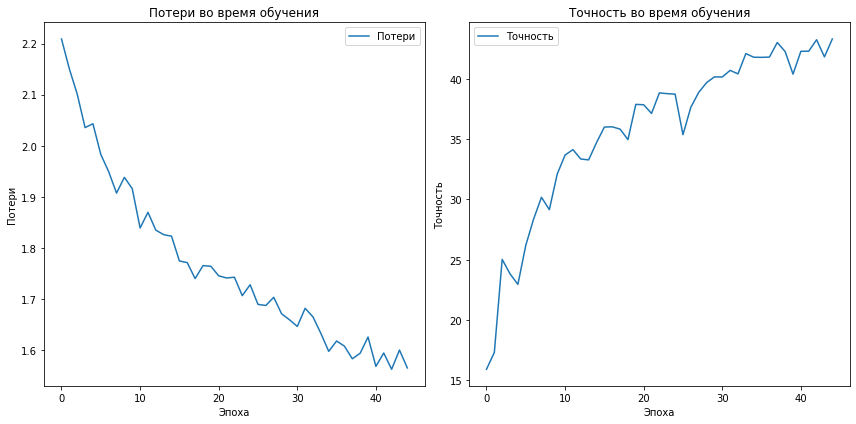

In [15]:
# Графики потерь и точности
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(losses, label='Потери')
plt.title('Потери во время обучения')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accs, label='Точность')
plt.title('Точность во время обучения')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()

plt.tight_layout()
plt.show()

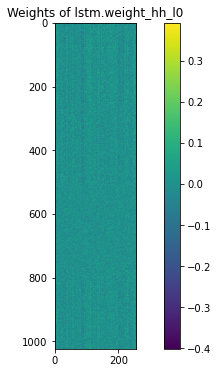

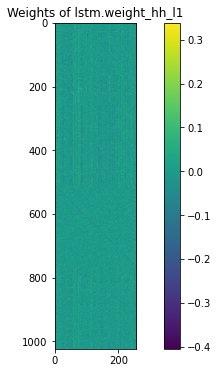

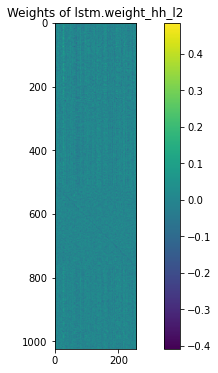

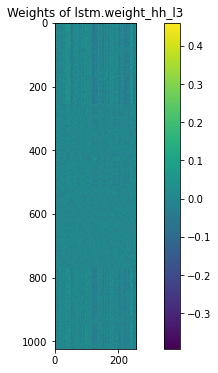

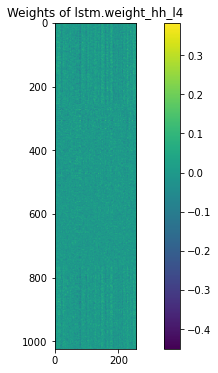

In [16]:
# Визуализация весов LSTM
for name, param in model.named_parameters():
    if 'weight_hh' in name:
        plt.figure(figsize=(10, 6))
        plt.imshow(param.detach().cpu().numpy(), cmap='viridis')
        plt.title(f"Weights of {name}")
        plt.colorbar()
        plt.show()

На графиках видно, что модель показывает результат лучше, чем Mamba, однако времени на ее обучение ушло больше